In [9]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import json
import datetime
import time
import jsonlines
from PIL import Image
from scipy.optimize import curve_fit
import scipy as sy
import pickle as pkl
import seaborn as sns
from os.path import join as oj
import sklearn.model_selection
import sklearn.linear_model
import scipy.stats
import viz
from tqdm import tqdm
PROCESSED_DIR = 'processed'
DIRECTIONS_DIR = '../data/annotation-dataset-stylegan2/linear_models/new' # path to many datasets, includes on directory before the below dirs
GENERATING_LATENTS_DIR = '../data/annotation-dataset-stylegan2/data'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# loading

**load gt latents**

In [10]:
latents = np.load(oj(GENERATING_LATENTS_DIR, 'W.npy'))

**load annotations in different directions**

In [11]:
annotations_dict = pkl.load(open(oj(PROCESSED_DIR, '01_annotations_dict.pkl'), 'rb'))
annotations_dict_names = pkl.load(open(oj(PROCESSED_DIR, '01_annotations_labels_dict.pkl'), 'rb'))

# rename keys
annotations_dict = {k.replace('calibration-random-v2-', '').replace('-000', ''): annotations_dict[k]
                    for k in annotations_dict}
attrs = ['age', 'facial-hair', 'skin-color', 'gender', 'hair-length', 'makeup']
N = len(attrs)

# fitting better linear models

1it [00:00,  2.55it/s]

0.8103440682755905


2it [00:00,  2.57it/s]

0.5223896953981586


3it [00:01,  2.61it/s]

0.6546381309535353


4it [00:01,  2.60it/s]

0.8717742788020989


5it [00:01,  2.60it/s]

0.8878656192766478


6it [00:02,  2.60it/s]

0.7307831006844667


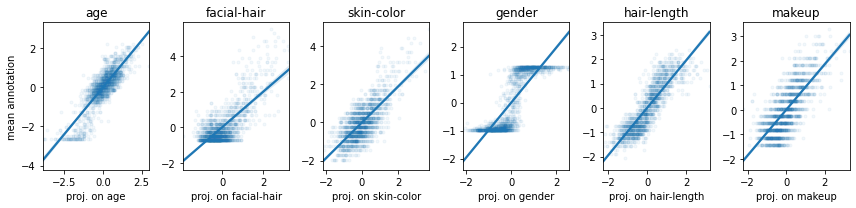

In [13]:
X = latents
R = 1
C = N
plt.figure(figsize=(C * 2, 3))
for i, attr in tqdm(enumerate(attrs)):
    attr_to_proj = attr
    y = annotations_dict[attr].mean(axis=1)
    y = (y - y.mean()) / (y.std())
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
        X, y, test_size=0.3, random_state=42)
    m = sklearn.linear_model.RidgeCV()
    m.fit(X_train, y_train)
    pkl.dump(m, open(oj(PROCESSED_DIR, f'03_m_{attr}.pkl'), 'wb'))
    projections = m.predict(X_test)
    
    plt.subplot(R, C, i + 1)
    plt.title(attr)
    sns.regplot(projections, y_test, marker='.', scatter_kws={'alpha': 0.05})
    print(scipy.stats.spearmanr(projections, y_test).correlation)
    if i == 0:
        plt.ylabel('mean annotation')
    plt.xlabel(f'proj. on {attr_to_proj}')
#     plt.xlabel('projection onto linear direction')
#     plt.plot(projections, mean_attr, '.')
plt.tight_layout()

**how independent are they**

100%|██████████| 6/6 [00:06<00:00,  1.05s/it]


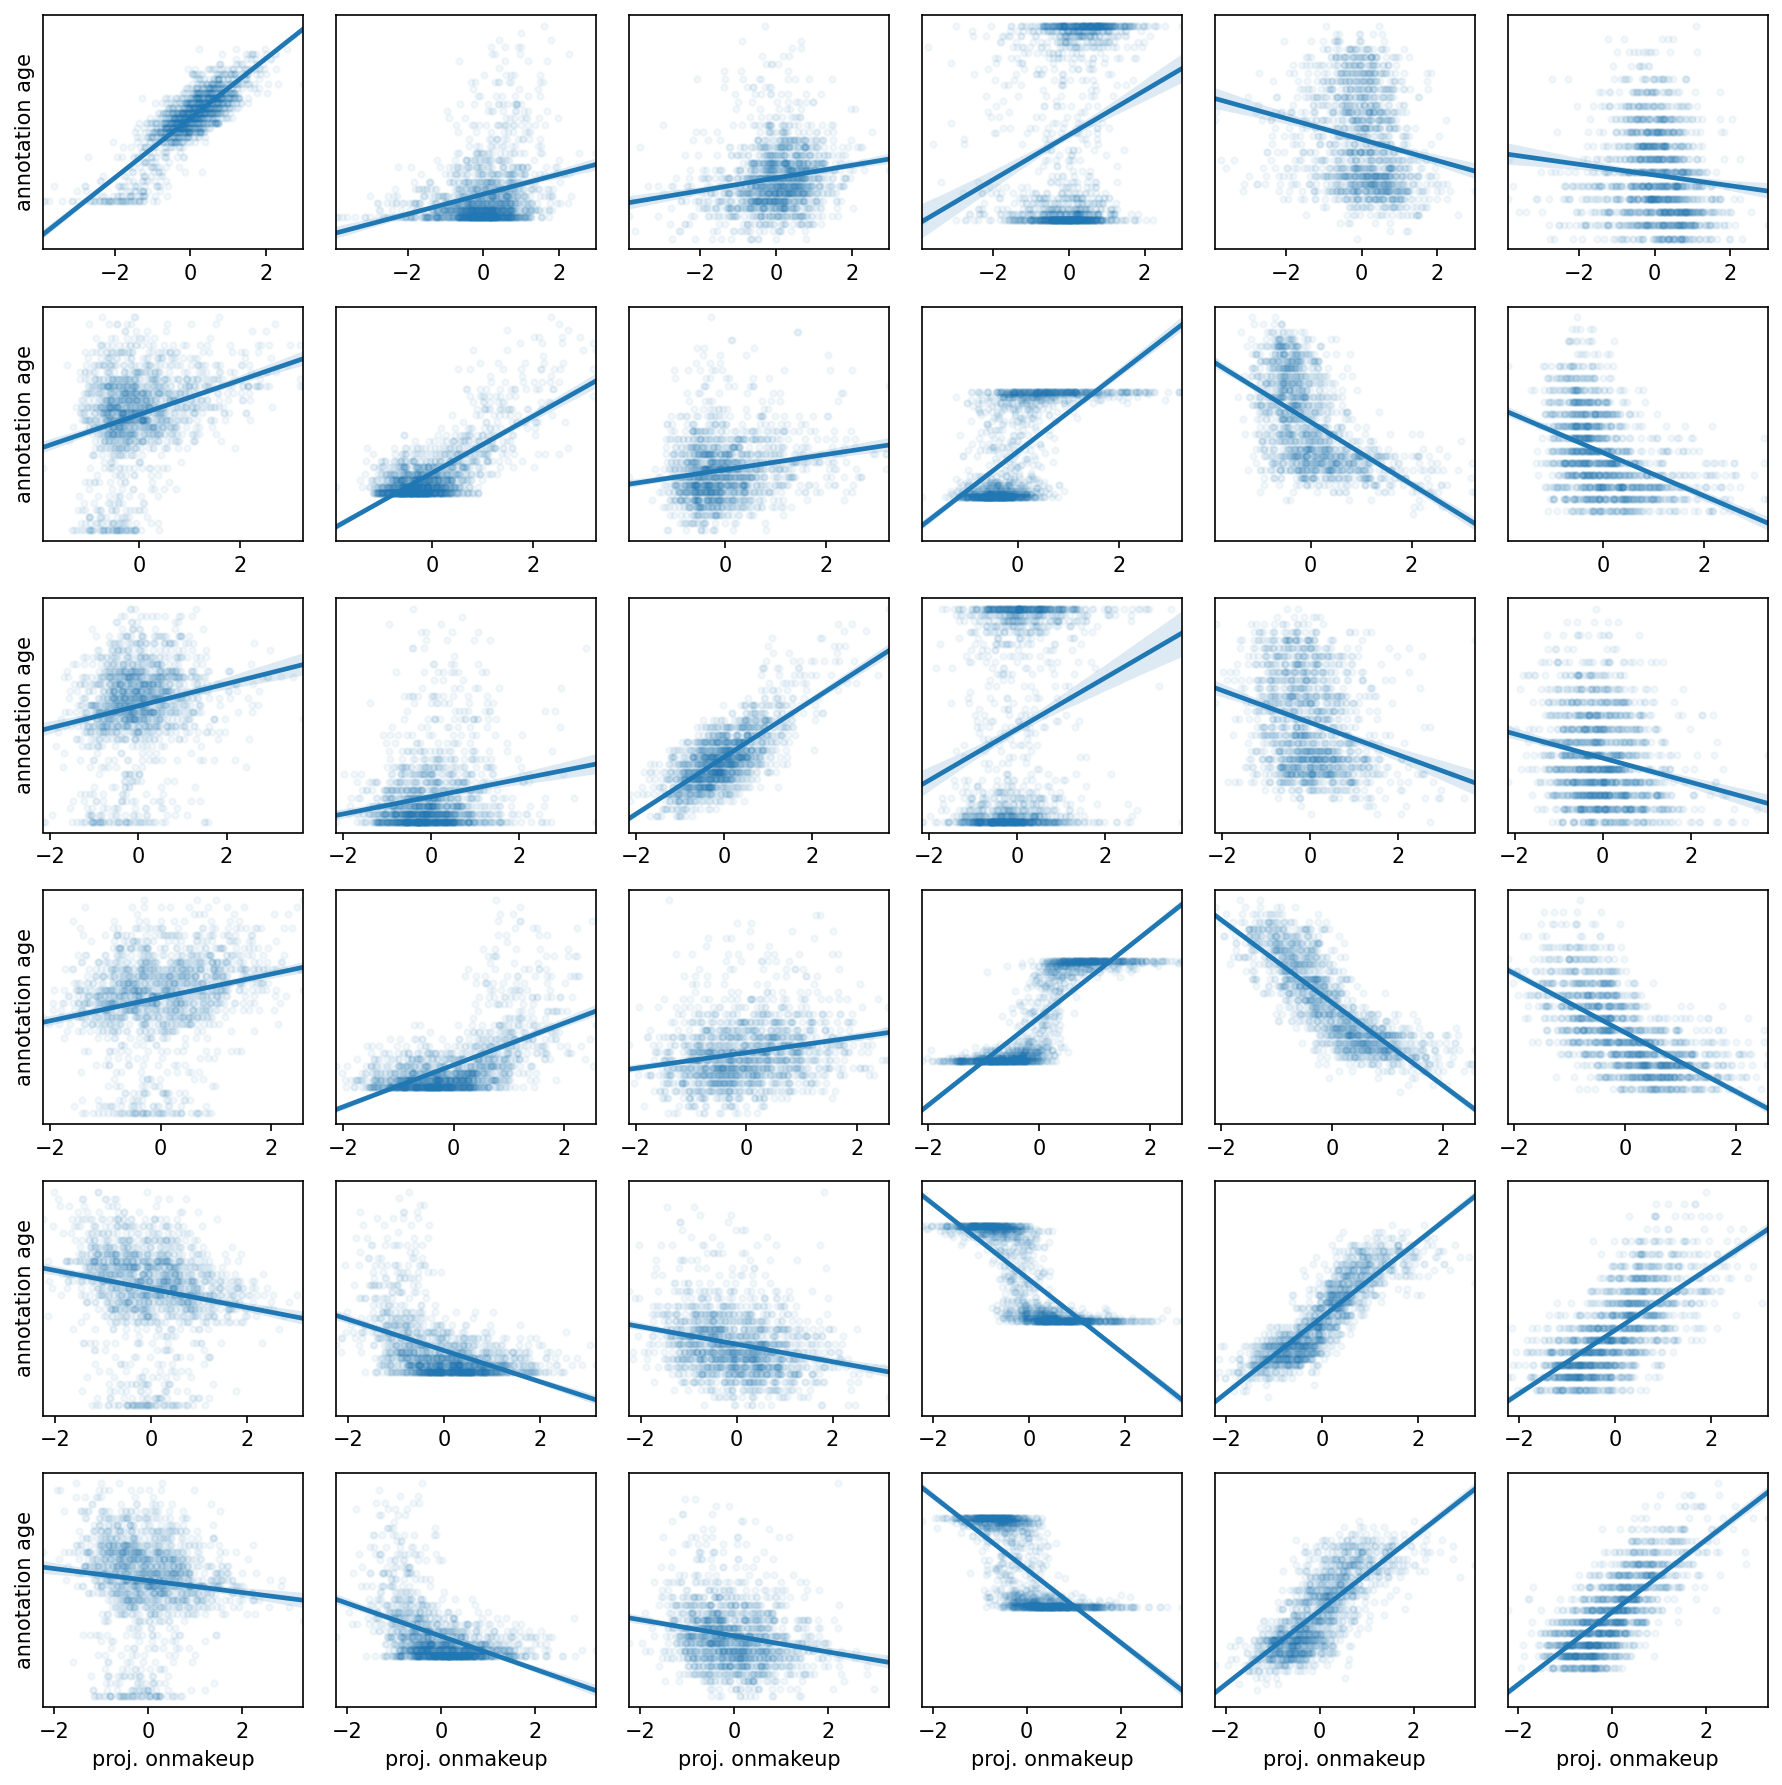

In [6]:
R, C = N, N
N = len(attrs)
spearman_mat = np.zeros((N, N))
i = 0
plt.figure(figsize=(12, 12), dpi=150)
for r in tqdm(range(N)):
    attr = attrs[r]
    y = annotations_dict[attr].mean(axis=1)
    y = (y - y.mean()) / (y.std())
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
        X, y, test_size=0.3, random_state=42)
    m = sklearn.linear_model.RidgeCV()
    m.fit(X_train, y_train)
    
    for c in range(N):
        attr_test = attrs[c]
        projections = m.predict(X_test)
        y = annotations_dict[attr_test].mean(axis=1)
        y = (y - y.mean()) / (y.std())
        y_train, y_test = sklearn.model_selection.train_test_split(
            y, test_size=0.3, random_state=42)     

        plt.subplot(R, C, i + 1)
#         if r == 0:
#             plt.title('measure ' + attr_test)
        if c == 0:
            plt.ylabel(f'annotation {attr_test}')
        
        sns.regplot(projections, y_test, marker='.', scatter_kws={'alpha': 0.05})
        spearman_mat[r, c] = np.corrcoef(projections, y_test)[0, 1]
        plt.yticks([])
        if r == N - 1:
            plt.xlabel('proj. on ' + attr)
        i += 1
plt.tight_layout() 

In [ ]:
plt.figure(dpi=300)
viz.corrplot(spearman_mat)
plt.xticks(range(N), attrs, rotation='vertical')
plt.ylabel('project on this attr')
plt.xlabel('measure this attr')
plt.yticks(range(N), attrs)
plt.colorbar()
plt.show()